# Couple channel model

In this notebook we will create a simple ocean-atmosphere system in a 1D channel. The two media are coupled through heat fluxes, but there is no exchange of momentum (could be added) as both are advected with pre-determined velocities. The governing equations for the atmospheric and the oceaning temperatures are

\begin{equation}
\frac{\partial T_a}{\partial t} = -u_a \frac{\partial T_a}{\partial x} + D_a\frac{\partial^2 T_a}{\partial x^2} +  \frac{F}{H_a \cdot C_{pa} \cdot \rho_a} - \frac{\alpha \epsilon T_a^4}{H_a \cdot C_{pa} \cdot \rho_a}
\end{equation}

\begin{equation}
\frac{\partial T_o}{\partial t}  = -u_o \frac{\partial T_o}{\partial x} + D_o\frac{\partial^2 T_o}{\partial x^2} - \frac{F}{H \cdot C_{po} \cdot \rho_o} + \frac{T_{AW}-T_o}{\tau} + \frac{F_{SW}}{H \cdot C_{po} \cdot \rho_o}
\end{equation}

and they are coupled through net heat flux term $F$

\begin{equation}
F=F_0+r_a \cdot C_{pa} \cdot v_a \cdot C_s \cdot (T_o-T_a)
\end{equation}

where $F_0$ is external forcing term which can be used to drive the model. This system lacks the latent heat flux which is why $C_s$ is taken to be 3E-3 by default i.e. three times higher than the conventional value 1E-3.

At the boundary we take the ocean and atmospheric temperatures to be in an equilibrium, and (depending on the settings) the boundary temperature feels the radiative fluxes and can be restored to an ambient temperature on an annual timescale. Similarly, the ocean temperature can be restored to an ambient temperature to represent vertical/horizontal reservoir.

## Load packages

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, LogNorm, SymLogNorm, from_levels_and_colors
from scipy import signal
import coupled_channel.cutils as cutils
from coupled_channel.surrogates import Surrogates

## Define model parameters

In [14]:
#
T0   = 273.15+20 # boundary or ambient temperature [K]
# combination of 50E3 grid cells and 40 grid cells will give 2000 km domain
xx   = 50.E3 # grid size [m]
nx   = 40    # number of grid cells
dt   = 3600. # one hour time step is convenient [s]
avep = 30*24*3600 # output frequency [s]
#
spatial_pattern=100.*np.ones(nx) # scaling for the heat flux forcing (pattern will be uniform)
#spatial_pattern = 5.*np.sin(np.arange(nx)*np.pi/(nx/2.)) #NAO like pattern
#
dT = 0.
#
SW0 = 115.-1*np.arange(nx) # background SW radiation [W/m^2]
SW_anom = 115.             # amplitude of the SW annual cycle [W/m^2]
#
Cs = 3.E-3 # exchange coefficient for bulk formula
va = 5.    # atmospheric advection [m/s]
Da = 1.E5  # atmospheric diffusion [m^2/s]
vo = 0.05  # ocean advection [m/s]
Do = 1.E2  # oceanic diffusion [m^2/s]
Hb = 1.E3  # boundary layer height in the atmosphere [m]
H  = 50   # ocean mixed layer thickness [m]
#

## EXAMPLE - CONTROL CLIMATE
As an example, we run the model for 20 years with constant shortwave forcing (12 month cosine) and daily restoring at the southern boundary to an ambient water which balances the net cooling by longwave radiation.

In [15]:
# set total run time to 20 years
tmax = 20*360*24*3600
#
tau_entrainment = np.inf #entrainment timescale with an ambient watermass [s]
period = 24*3600. #restoring timescale at the boundary [s]
#
args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':vo,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
#
# set the arguments
C         = cutils.set_model_constants(**args)
forcing   = None # no additional heat flux forcing
dt_f      = 0    # forcing time step is 0
ice_model = True # ice model will be used
atm_adv   = True # atmosphere will be advective


In [16]:
%time tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

Year  1.0 287.6474586474451 277.73174691369445
Year  2.0 287.647456767091 277.61682897005386
Year  3.0 287.647456767091 277.6168288884707
Year  4.0 287.647456767091 277.6168288884707
Year  5.0 287.647456767091 277.6168288884707
Year  6.0 287.647456767091 277.6168288884707
Year  7.0 287.647456767091 277.6168288884707
Year  8.0 287.647456767091 277.6168288884707
Year  9.0 287.647456767091 277.61682888847076
Year  10.0 287.647456767091 277.6168288884707
Year  11.0 287.647456767091 277.6168288884707
Year  12.0 287.647456767091 277.61682888847076
Year  13.0 287.647456767091 277.61682888847076
Year  14.0 287.647456767091 277.6168288884707
Year  15.0 287.647456767091 277.6168288884707
Year  16.0 287.647456767091 277.6168288884707
Year  17.0 287.647456767091 277.61682888847076
Year  18.0 287.647456767091 277.6168288884707
Year  19.0 287.647456767091 277.6168288884707
Year  20.0 287.647456767091 277.61682888847076
CPU times: user 30.1 s, sys: 280 ms, total: 30.4 s
Wall time: 30.7 s


In [17]:
#%time tas_out2, sst_out2, hice_out2, sflx_out2, sflx_f_out2, nt12, nt2, atm_DA_tendencies2, ocn_DA_tendencies2 = cutils.CoupledChannel2(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

Text(0.5, 0, 'Time [month]')

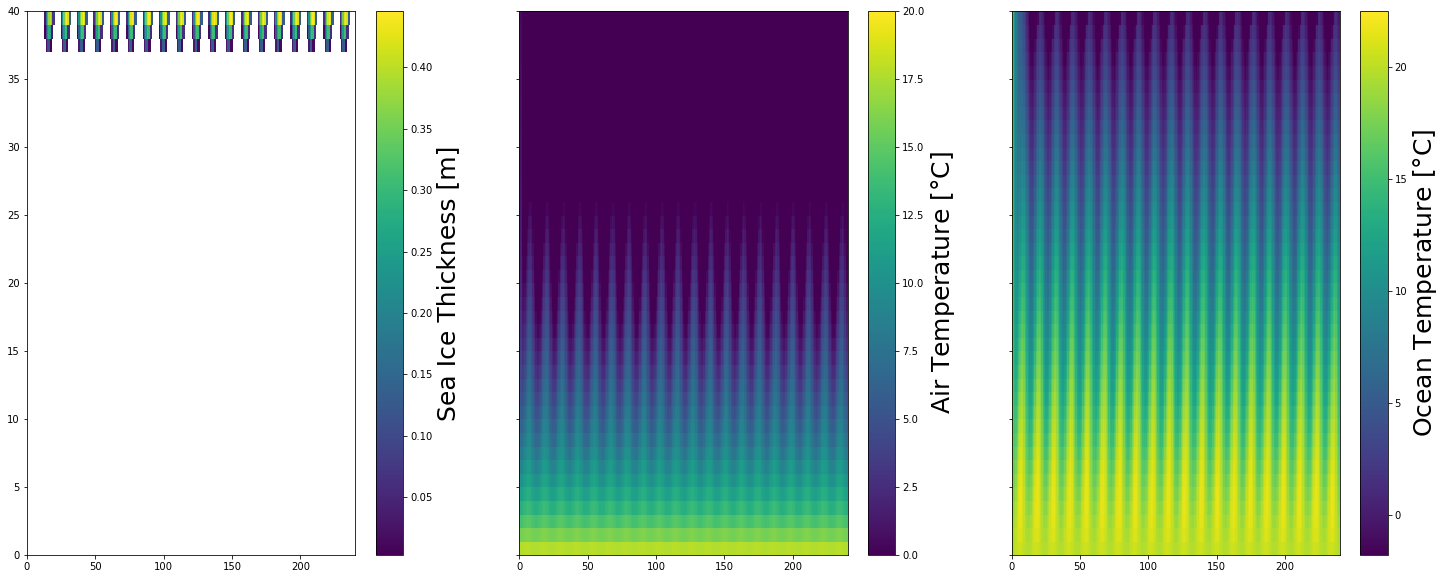

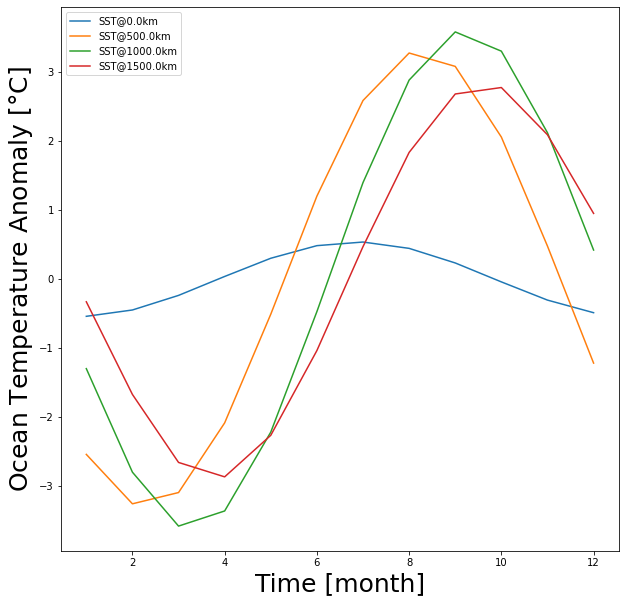

In [18]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(25,10))
#
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15,vmin=T0-273.15-20,vmax=T0-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15+2.5)
#
cbar1=plt.colorbar(mappable=cm1,ax=ax1)
cbar2=plt.colorbar(mappable=cm2,ax=ax2)
cbar3=plt.colorbar(mappable=cm3,ax=ax3)
#
cbar1.ax.set_ylabel('Sea Ice Thickness [m]',fontsize=25)
cbar2.ax.set_ylabel('Air Temperature [$\degree$C]',fontsize=25)
cbar3.ax.set_ylabel('Ocean Temperature [$\degree$C]',fontsize=25)
#
fig2,ax4 = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(10,10))
for j in range(0,C['nx'],10):
    ax4.plot(np.arange(1,13),sst_out[-360*24*3600//C['avep']:,j]-np.nanmean(sst_out[-360*24*3600//C['avep']:,j]),label='SST@'+str(C['xx']*j/1E3)+'km')

ax4.legend()
ax4.set_ylabel('Ocean Temperature Anomaly [$\degree$C]',fontsize=25)
ax4.set_xlabel('Time [month]',fontsize=25)

## EXAMPLE - CONTROL CLIMATE WITH VARIABLE BOUNDARY CONDITIONS

As an example, we run the model for 20 years with constant shortwave forcing (12 month sine) and daily restoring to a variable inflow temperatures which balance the net cooling by longwave radiation.

In [19]:
# set total run time to 10 years
tmax = 20*360*24*3600 #
C['dT'] = 2
#
T_boundary=C['T0']-C['dT']*np.cos(2*np.pi*(np.arange(0,C['tmax'],C['dt']))/(5*360*24*3600))
#
#plt.plot(T_boundary)
%time tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f,T_boundary=T_boundary, ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)

Year  1.0 286.5750486622409 276.6051007694898
Year  2.0 288.673248042351 277.76112473697486
Year  3.0 289.3524416008497 278.93913899052336
Year  4.0 287.67554814910596 278.2908987678616
Year  5.0 285.95700661721924 276.70592929228565
Year  6.0 286.5750413983053 276.37785362836354
Year  7.0 288.673248042351 277.7611243284717
Year  8.0 289.3524416008497 278.93913899033964
Year  9.0 287.67554814910596 278.29089876786156
Year  10.0 285.95700661721924 276.70592929228565
Year  11.0 286.5750413983053 276.37785362836354
Year  12.0 288.673248042351 277.76112432847174
Year  13.0 289.3524416008497 278.9391389903397
Year  14.0 287.67554814910596 278.29089876786156
Year  15.0 285.95700661721924 276.70592929228565
Year  16.0 286.5750413983053 276.37785362836354
Year  17.0 288.673248042351 277.7611243284717
Year  18.0 289.3524416008497 278.9391389903397
Year  19.0 287.675548149106 278.2908987678616
Year  20.0 285.95700661721924 276.70592929228565
CPU times: user 30.7 s, sys: 216 ms, total: 30.9 s
Wal

Text(0.5, 0, 'Time [month]')

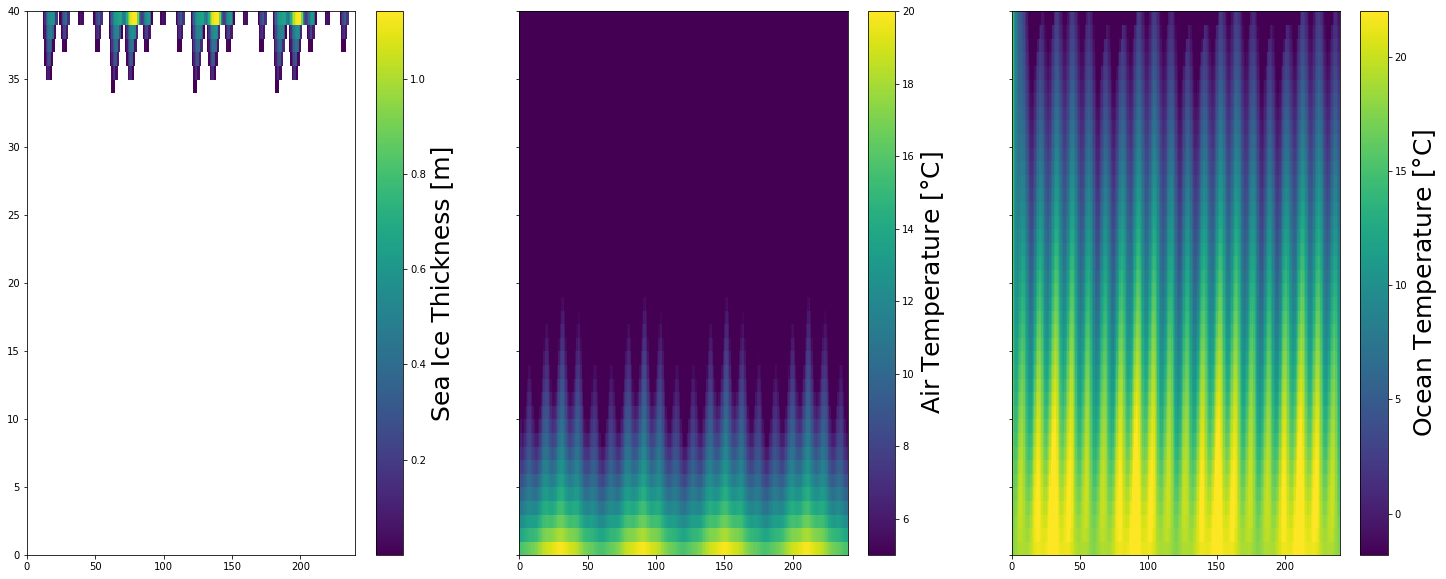

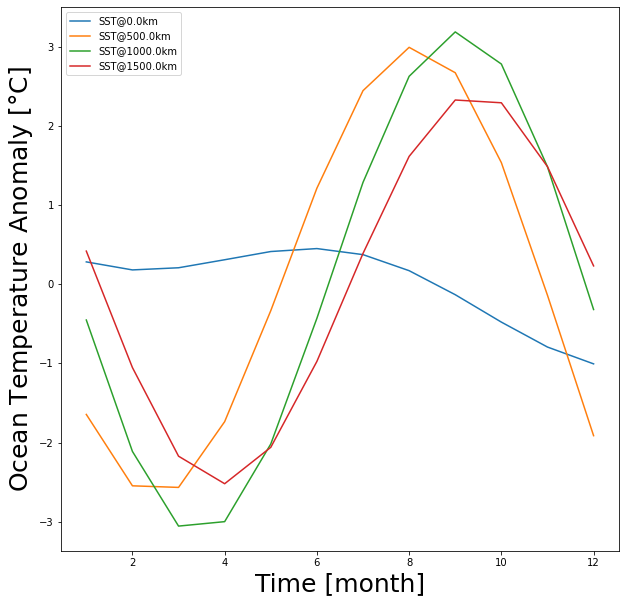

In [20]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(25,10))
#
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15,vmin=T0-273.15-15,vmax=T0-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15+2)
#
cbar1=plt.colorbar(mappable=cm1,ax=ax1)
cbar2=plt.colorbar(mappable=cm2,ax=ax2)
cbar3=plt.colorbar(mappable=cm3,ax=ax3)
#
cbar1.ax.set_ylabel('Sea Ice Thickness [m]',fontsize=25)
cbar2.ax.set_ylabel('Air Temperature [$\degree$C]',fontsize=25)
cbar3.ax.set_ylabel('Ocean Temperature [$\degree$C]',fontsize=25)
#
fig2,ax4 = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(10,10))
for j in range(0,C['nx'],10):
    ax4.plot(np.arange(1,13),sst_out[-360*24*3600//C['avep']:,j]-np.nanmean(sst_out[-360*24*3600//C['avep']:,j]),label='SST@'+str(C['xx']*j/1E3)+'km')

ax4.legend()
ax4.set_ylabel('Ocean Temperature Anomaly [$\degree$C]',fontsize=25)
ax4.set_xlabel('Time [month]',fontsize=25)

## EXERCISE 1 - SLAB OCEAN

Show that by diagnosing the fluxes from a fully coupled simulation you can replicate the same control climate.

In [21]:
# 
#H=50
#va=5
#args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':0.05,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
# first run a control case for 10 years without any time-variable forcing
tmax=20*360*24*3600
C['tmax']=tmax
C['dT'] = 0.0
#C    = cutils.set_model_constants(**args)
forcing = None
#
#T_boundary=C['T0']-C['dT']*np.cos(2*np.pi*(np.arange(0,C['tmax'],C['dt']))/(360*24*3600))
#
tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)


Year  1.0 287.6474586474451 277.73174691369445
Year  2.0 287.647456767091 277.61682897005386
Year  3.0 287.647456767091 277.6168288884707
Year  4.0 287.647456767091 277.6168288884707
Year  5.0 287.647456767091 277.6168288884707
Year  6.0 287.647456767091 277.6168288884707
Year  7.0 287.647456767091 277.6168288884707
Year  8.0 287.647456767091 277.6168288884707
Year  9.0 287.647456767091 277.61682888847076
Year  10.0 287.647456767091 277.6168288884707
Year  11.0 287.647456767091 277.6168288884707
Year  12.0 287.647456767091 277.61682888847076
Year  13.0 287.647456767091 277.61682888847076
Year  14.0 287.647456767091 277.6168288884707
Year  15.0 287.647456767091 277.6168288884707
Year  16.0 287.647456767091 277.6168288884707
Year  17.0 287.647456767091 277.61682888847076
Year  18.0 287.647456767091 277.6168288884707
Year  19.0 287.647456767091 277.6168288884707
Year  20.0 287.647456767091 277.61682888847076


In [22]:
# then run a case without ocean advection, but input the DA tendencies using the last 10 years of the previous case 
atm_DA_tendencies2 = atm_DA_tendencies[-int(360*24*3600//C['dt']):]
ocn_DA_tendencies2 = ocn_DA_tendencies[-int(360*24*3600//C['dt']):]
#
tmax=20*360*24*3600
C['tmax']=tmax
C['vo']=0.0 #stagnant ocean
tas_out_slab, sst_out_slab, hice_out_slab, sflx_out_slab, sflx_f_out_slab, nt1, nt = cutils.CoupledChannel(C,forcing, dt_f=dt_f,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,ocn_DA_tendencies=ocn_DA_tendencies2,atm_DA_tendencies=atm_DA_tendencies2)
#

Year  1.0 290.64495942536064 286.40485688467
Year  2.0 289.2691633272004 282.6219401032791
Year  3.0 288.5268493284461 280.4855577324844
Year  4.0 288.12491156241794 279.26698034358094
Year  5.0 287.9068590104858 278.56797707819925
Year  6.0 287.788442009113 278.16571656357274
Year  7.0 287.724097499895 277.9337950537983
Year  8.0 287.68912378451614 277.79993884139463
Year  9.0 287.67011106478276 277.72263454976127
Year  10.0 287.65977426828687 277.67797409404824
Year  11.0 287.65415410385754 277.65216742693116
Year  12.0 287.6510983126446 277.63725349210915
Year  13.0 287.6494367962147 277.6286339865938
Year  14.0 287.6485333776055 277.6236521476938
Year  15.0 287.64804215845635 277.6207727148283
Year  16.0 287.64777506542373 277.619108421062
Year  17.0 287.6476298374115 277.61814646255505
Year  18.0 287.64755087171267 277.6175904499794
Year  19.0 287.647507935199 277.6172690735663
Year  20.0 287.6474845890552 277.6170833170637


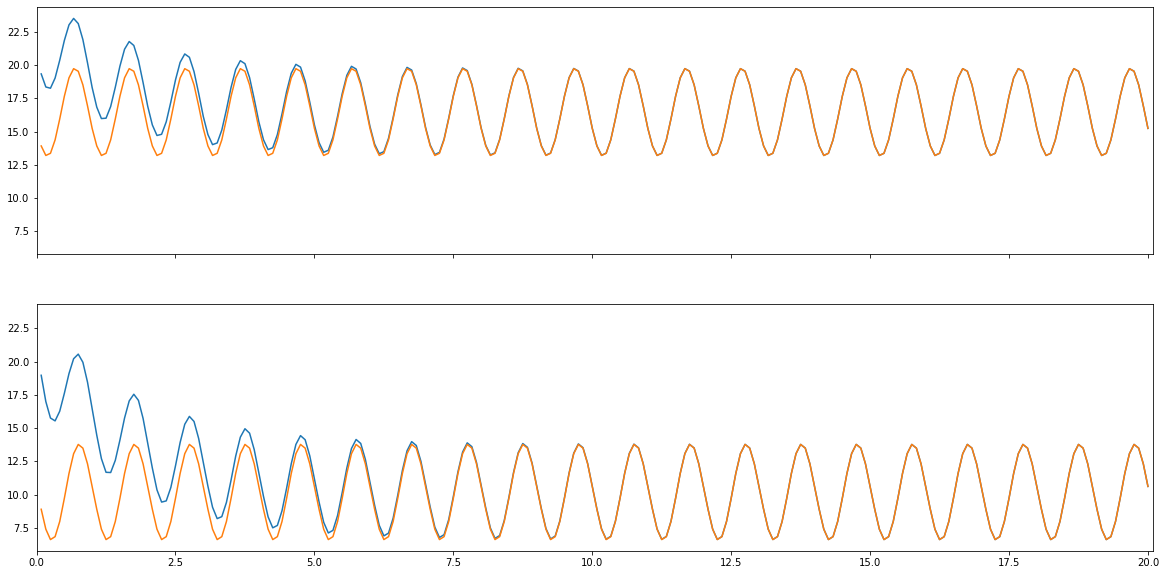

In [24]:
fig,axes = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True,figsize=(20,10))
diag_points=[10,20]
timeaxis=np.arange(1/12,20,1/12)
for a,ax in enumerate(axes.flatten()):
    j=diag_points[a]
    ax.plot(timeaxis,sst_out_slab[:,j]-273.15)
    ax.plot(timeaxis,np.tile(sst_out[-360*24*3600//C['avep']:,j],20)-273.15)
    ax.set_xlim(0,20+1/12)
#

Text(0.5, 0, 'Time [month]')

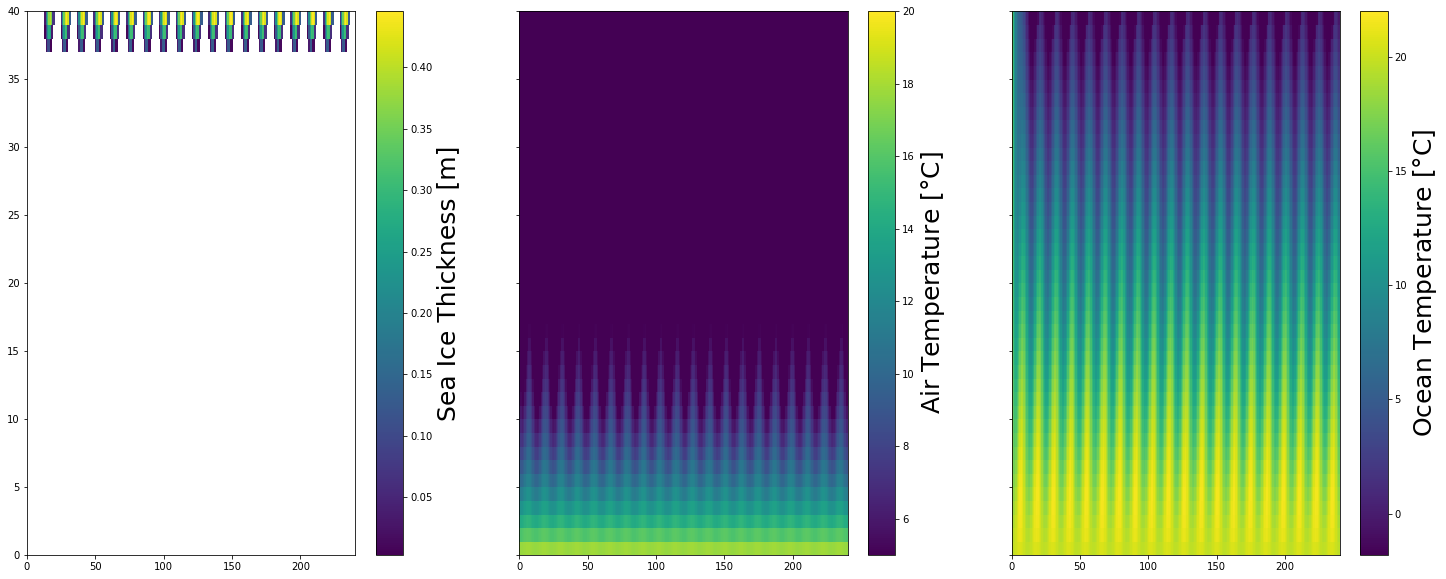

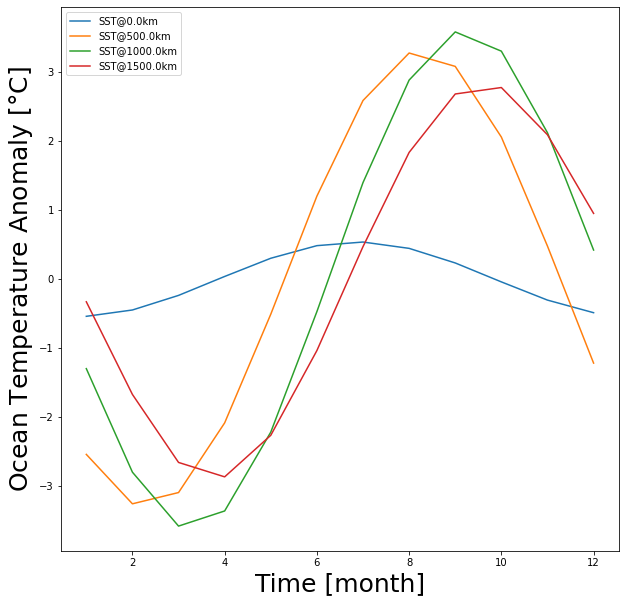

In [25]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(25,10))
#
cm1=ax1.pcolormesh(hice_out.T)
cm2=ax2.pcolormesh(tas_out.T-273.15,vmin=T0-273.15-15,vmax=T0-273.15)
cm3=ax3.pcolormesh(sst_out.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15+2)
#
cbar1=plt.colorbar(mappable=cm1,ax=ax1)
cbar2=plt.colorbar(mappable=cm2,ax=ax2)
cbar3=plt.colorbar(mappable=cm3,ax=ax3)
#
cbar1.ax.set_ylabel('Sea Ice Thickness [m]',fontsize=25)
cbar2.ax.set_ylabel('Air Temperature [$\degree$C]',fontsize=25)
cbar3.ax.set_ylabel('Ocean Temperature [$\degree$C]',fontsize=25)
#
fig2,ax4 = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(10,10))
for j in range(0,C['nx'],10):
    ax4.plot(np.arange(1,13),sst_out[-360*24*3600//C['avep']:,j]-np.nanmean(sst_out[-360*24*3600//C['avep']:,j]),label='SST@'+str(C['xx']*j/1E3)+'km')

ax4.legend()
ax4.set_ylabel('Ocean Temperature Anomaly [$\degree$C]',fontsize=25)
ax4.set_xlabel('Time [month]',fontsize=25)

## Exercise 2 - Perturbation Study



In [27]:
# 
C['tmax'] = 20*360*24*3600
C['vo']   = 0.05
forcing = None
# CASE 1 WITH 20 DEGREE INFLOW
C['T0']   = 273.15+20
tas_out0, sst_out0, hice_out0, sflx_out0, sflx_f_out0, nt10, nt0, atm_DA_tendencies0, ocn_DA_tendencies0 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)
#
# CASE 2 WITH 19 DEGREE INFLOW
#
C['T0']   = 273.15+18
tas_out1, sst_out1, hice_out1, sflx_out1, sflx_f_out1, nt11, nt1, atm_DA_tendencies1, ocn_DA_tendencies1 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)
#


Year  1.0 287.6474586474451 277.73174691369445
Year  2.0 287.647456767091 277.61682897005386
Year  3.0 287.647456767091 277.6168288884707
Year  4.0 287.647456767091 277.6168288884707
Year  5.0 287.647456767091 277.6168288884707
Year  6.0 287.647456767091 277.6168288884707
Year  7.0 287.647456767091 277.6168288884707
Year  8.0 287.647456767091 277.6168288884707
Year  9.0 287.647456767091 277.61682888847076
Year  10.0 287.647456767091 277.6168288884707
Year  11.0 287.647456767091 277.6168288884707
Year  12.0 287.647456767091 277.61682888847076
Year  13.0 287.647456767091 277.61682888847076
Year  14.0 287.647456767091 277.6168288884707
Year  15.0 287.647456767091 277.6168288884707
Year  16.0 287.647456767091 277.6168288884707
Year  17.0 287.647456767091 277.61682888847076
Year  18.0 287.647456767091 277.6168288884707
Year  19.0 287.647456767091 277.6168288884707
Year  20.0 287.647456767091 277.61682888847076
Year  1.0 285.8393667140292 276.3052429114283
Year  2.0 285.8393648855387 276.193

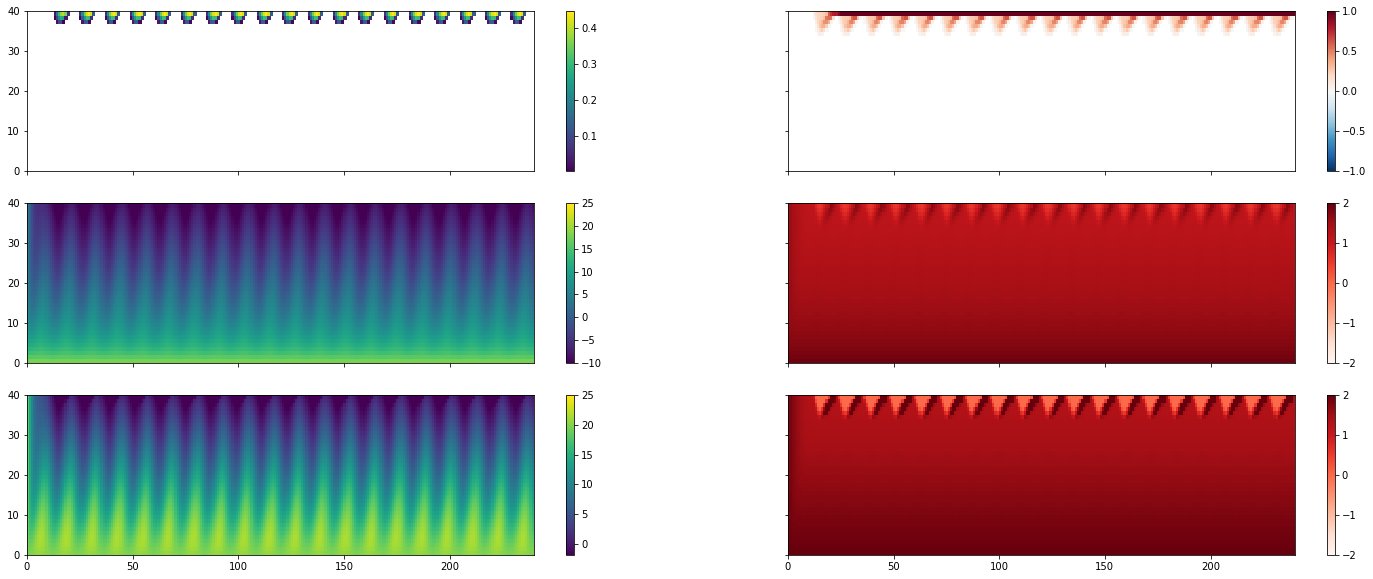

In [45]:
fig, axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(25,10))
#
axes=axes.flatten()
cms={}
cms[0]=axes[0].pcolormesh(hice_out0.T)
cms[2]=axes[2].pcolormesh(tas_out0.T-273.15,vmin=T0-273.15-30,vmax=T0-273.15+5)
cms[4]=axes[4].pcolormesh(sst_out0.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15+5)
#
dhice = np.concatenate([hice_out0[np.newaxis,],hice_out1[np.newaxis,]],0)
dhice[np.where(np.isnan(dhice))]=0
dhice=np.diff(dhice,axis=0).squeeze()
dhice[np.where(dhice==0)]=np.nan
cms[1]=axes[1].pcolormesh(dhice.T,vmin=-1,vmax=1,cmap=mpl.cm.RdBu_r)
cms[3]=axes[3].pcolormesh(tas_out0.T-tas_out1.T,vmin=0,vmax=2,cmap=mpl.cm.Reds)
cms[5]=axes[5].pcolormesh(sst_out0.T-sst_out1.T,vmin=0,vmax=2,cmap=mpl.cm.Reds)
#
cbars={}
for a, ax in enumerate(axes.flatten()):
    cbars[a]=plt.colorbar(mappable=cms[a],ax=ax)
#

## Realistic Forcing

In [46]:
#forcings
#nao=np.loadtxt('norm.nao.monthly.b5001.current.ascii.table')[:-1,-1]; dt_f=30*24*3600 #66 years of monthly NAO
nao0 = np.loadtxt('../data/raw/norm.daily.nao.index.b500101.current.ascii')[:,-1]; dt_f=24*3600 #66 yeas of daily NAO
#
nao_surrogate    = Surrogates(np.tile(nao0[:50*360,np.newaxis],22).T)
nao_s = nao_surrogate.refined_AAFT_surrogates(np.tile(nao0[:50*360,np.newaxis],22).T,10).flatten().squeeze()
nao_s = -2*(0.5-(nao_s - np.min(nao_s,0))/np.max((nao_s - np.min(nao_s,0)),0))
#
nao_white=1-2*np.random.rand(len(nao_s))
#
tmax = (len(nao_s)-1*360.)*dt_f
#
forcing = nao_s #None #100*nao
forcing_str = 'synthetic_nao_random_spatial'



Generated an instance of the Surrogates class.
Generating correlated noise surrogates...


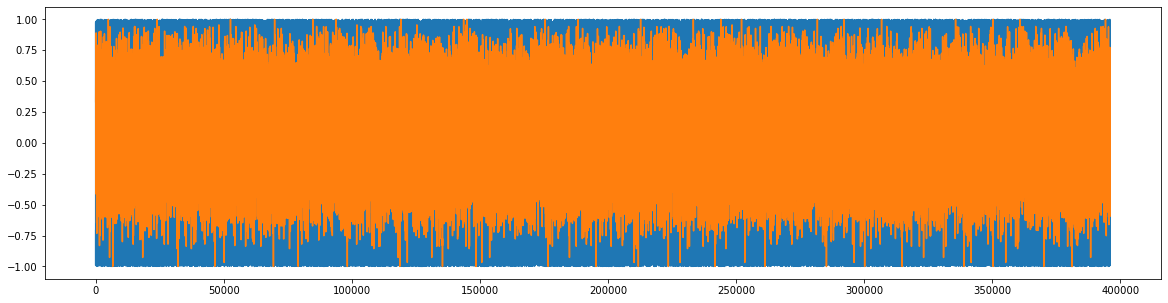

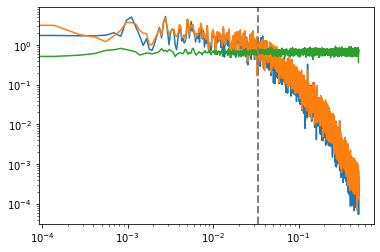

In [47]:
plt.figure(figsize=(20,5))
#
plt.plot(nao_white)
plt.plot(nao_s)
#
plt.figure()
f0,p0 = signal.welch(-2*(0.5-(nao0 - np.min(nao0,0))/np.max((nao0 - np.min(nao0,0)),0)),fs=1,nperseg=20*360)
f1,p1 = signal.welch(nao_s,fs=1,nperseg=20*360)
f2,p2 = signal.welch(nao_white,fs=1,nperseg=20*360)
plt.loglog(f0,p0)
plt.loglog(f1,p1)
plt.loglog(f2,p2)
plt.axvline(x=1/30,lw=2,ls='--',color='gray')

In [52]:
# RUN THE MODEL
for nf_str,nao in enumerate([nao_s]):
    #
    tmax = 20*360*24*3600
    args = {'tau_entrainment':tau_entrainment,'Do':Do,'SW0':SW0,'SW_anom':SW_anom,'H':H, 'Cs':Cs,'va':va,'Da':Da,'vo':0.05,'T0':T0,'tmax':tmax,'dt':dt,'dT':dT,'period':period,'avep':avep,'xx':xx,'nx':nx}
    # first run a control case for 10 years without any forcing
    C    = cutils.set_model_constants(**args)
    #
    forcing = None
    tas_out, sst_out, hice_out, sflx_out, sflx_f_out, nt1, nt, atm_DA_tendencies, ocn_DA_tendencies = cutils.CoupledChannel(C,forcing, dt_f=dt_f, ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,return_coupled_fluxes=True)
    #
    atm_DA_tendencies2 = atm_DA_tendencies[int(-360*24*3600//C['dt']):]
    ocn_DA_tendencies2 = ocn_DA_tendencies[int(-360*24*3600//C['dt']):]
    # then run a fully coupled case with varying forcing
    forcing = nao
    args['tmax'] = tmax
    C = cutils.set_model_constants(**args)
    #
    tas_out0, sst_out0, hice_out0, sflx_out0, sflx_f_out0, nt1_0, nt0 = cutils.CoupledChannel(C,forcing, dt_f=dt_f, restoring=False,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern)
    # then run a slab ocean case (i.e. ocean advection and diffusion tendencies from the control case)
    C['vo']=0.0 #stagnant ocean
    tas_out1, sst_out1, hice_out1, sflx_out1, sflx_f_out1, nt1_1, nt1 = cutils.CoupledChannel(C,forcing, dt_f=dt_f,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,ocn_DA_tendencies=ocn_DA_tendencies2,atm_DA_tendencies=atm_DA_tendencies2)
    # then run a slab_atm (i.e. atm advection and diffusion tendencies from the control case)
    C['vo']=0.05 #set back
    tas_out2, sst_out2, hice_out2, sflx_out2, sflx_f_out2, nt1_2, nt2 = cutils.CoupledChannel(C,forcing, dt_f=dt_f,ice_model=ice_model,atm_adv=atm_adv,spatial_pattern=spatial_pattern,atm_DA_tendencies=atm_DA_tendencies2)
    #

Year  1.0 287.6474586474451 277.73174691369445
Year  2.0 287.647456767091 277.61682897005386
Year  3.0 287.647456767091 277.6168288884707
Year  4.0 287.647456767091 277.6168288884707
Year  5.0 287.647456767091 277.6168288884707
Year  6.0 287.647456767091 277.6168288884707
Year  7.0 287.647456767091 277.6168288884707
Year  8.0 287.647456767091 277.6168288884707
Year  9.0 287.647456767091 277.61682888847076
Year  10.0 287.647456767091 277.6168288884707
Year  11.0 287.647456767091 277.6168288884707
Year  12.0 287.647456767091 277.61682888847076
Year  13.0 287.647456767091 277.61682888847076
Year  14.0 287.647456767091 277.6168288884707
Year  15.0 287.647456767091 277.6168288884707
Year  16.0 287.647456767091 277.6168288884707
Year  17.0 287.647456767091 277.61682888847076
Year  18.0 287.647456767091 277.6168288884707
Year  19.0 287.647456767091 277.6168288884707
Year  20.0 287.647456767091 277.61682888847076
Year  1.0 287.54801014519666 277.44500680357356
Year  2.0 287.61402413031306 277.

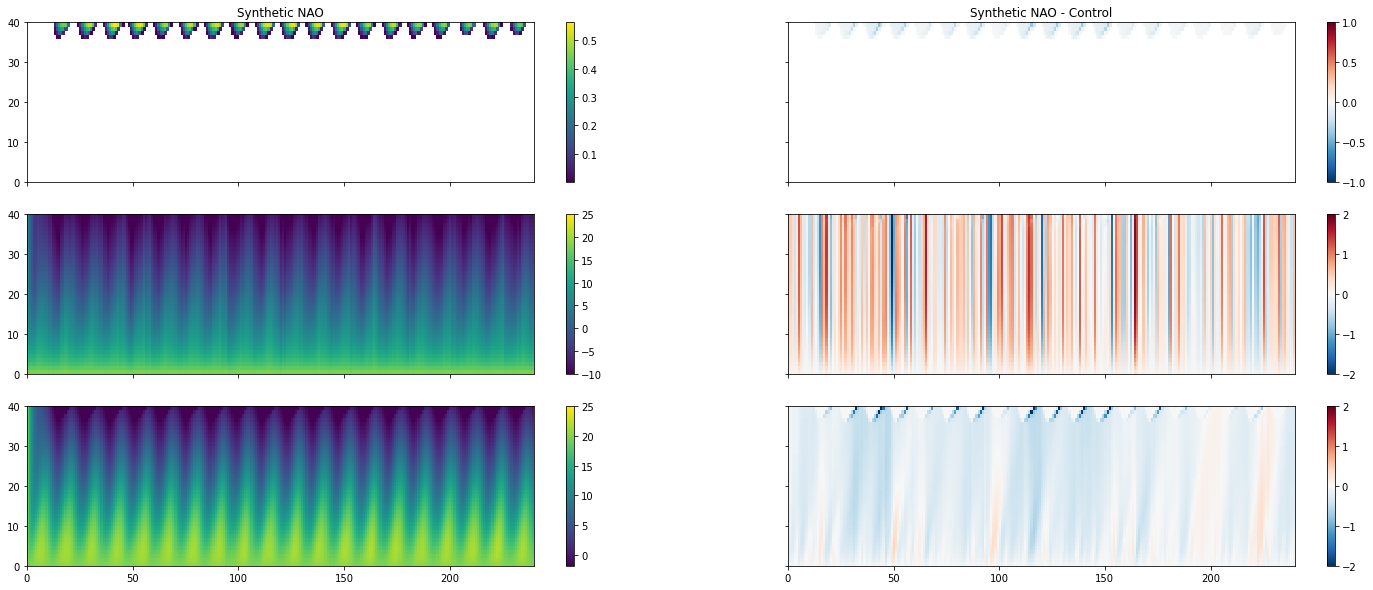

In [60]:
fig, axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(25,10))
#
axes=axes.flatten()
cms={}
cms[0]=axes[0].pcolormesh(hice_out0.T)
cms[2]=axes[2].pcolormesh(tas_out0.T-273.15,vmin=T0-273.15-30,vmax=T0-273.15+5)
cms[4]=axes[4].pcolormesh(sst_out0.T-273.15,vmin=C['Tf']-273.15,vmax=T0-273.15+5)
#
dhice = np.concatenate([hice_out0[np.newaxis,],hice_out[np.newaxis,]],0)
dhice[np.where(np.isnan(dhice))]=0
dhice=np.diff(dhice,axis=0).squeeze()
dhice[np.where(dhice==0)]=np.nan
cms[1]=axes[1].pcolormesh(dhice.T,vmin=-1,vmax=1,cmap=mpl.cm.RdBu_r)
cms[3]=axes[3].pcolormesh(tas_out0.T-tas_out.T,vmin=-2,vmax=2,cmap=mpl.cm.RdBu_r)
cms[5]=axes[5].pcolormesh(sst_out0.T-sst_out.T,vmin=-2,vmax=2,cmap=mpl.cm.RdBu_r)
#
axes[0].set_title('Synthetic NAO')
axes[1].set_title('Synthetic NAO - Control')
cbars={}
for a, ax in enumerate(axes.flatten()):
    cbars[a]=plt.colorbar(mappable=cms[a],ax=ax)